## Import libraries

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST/Data/", one_hot=True)

Extracting ./MNIST/Data/train-images-idx3-ubyte.gz
Extracting ./MNIST/Data/train-labels-idx1-ubyte.gz
Extracting ./MNIST/Data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/Data/t10k-labels-idx1-ubyte.gz


## Hyperparameters

In [30]:
total_epoch = 10
batch_size  = 100
learning_rate = 0.002

n_hidden = 256
n_input  = 28 * 28
n_noise  = 128 

## Model

In [21]:
X = tf.placeholder(tf.float32, [None, n_input])
Z = tf.placeholder(tf.float32, [None, n_noise])

G_W1 = tf.Variable(tf.random_normal([n_noise, n_hidden], stddev=0.01))
G_b1 = tf.Variable(tf.zeros([n_hidden]))
G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input], stddev=0.01))
G_b2 = tf.Variable(tf.zeros([n_input]))

D_W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev=0.01))
D_b1 = tf.Variable(tf.zeros([n_hidden]))
D_W2 = tf.Variable(tf.random_normal([n_hidden, 1], stddev=0.01))
D_b2 = tf.Variable(tf.zeros([1]))

## Neural Network

In [22]:
def generator(noise_z):
    hidden = tf.nn.relu(
                    tf.matmul(noise_z, G_W1) + G_b1)
    output = tf.nn.sigmoid(
                    tf.matmul(hidden, G_W2) + G_b2)

    return output


def discriminator(inputs):
    hidden = tf.nn.relu(
                    tf.matmul(inputs, D_W1) + D_b1)
    output = tf.nn.sigmoid(
                    tf.matmul(hidden, D_W2) + D_b2)

    return output


def get_noise(batch_size, n_noise):
    return np.random.normal(size=(batch_size, n_noise))

## Generate & Discriminate

In [28]:
G = generator(Z)
D_gene = discriminator(G)
D_real = discriminator(X)

loss_D = tf.reduce_mean(tf.log(tf.maximum(D_real, 1e-9)) + tf.log(tf.maximum(1 - D_gene, 1e-9)))
loss_G = tf.reduce_mean(tf.log(tf.maximum(D_gene, 1e-9)))

D_var_list = [D_W1, D_b1, D_W2, D_b2]
G_var_list = [G_W1, G_b1, G_W2, G_b2]

train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D,
                                                         var_list=D_var_list)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G,
                                                         var_list=G_var_list)

## Train

In [31]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        _, loss_val_D = sess.run([train_D, loss_D],
                                 feed_dict={X: batch_xs, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],
                                 feed_dict={Z: noise})

    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Z: noise})

        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))

        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i], (28, 28)))

        #plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.close(fig)

print('Optimization Finished!')

Epoch: 0000 D loss: -0.1276 G loss: -6.825
Epoch: 0001 D loss: -0.03443 G loss: -6.577
Epoch: 0002 D loss: -0.05652 G loss: -6.364
Epoch: 0003 D loss: -0.06248 G loss: -5.99
Epoch: 0004 D loss: -0.3259 G loss: -4.631
Epoch: 0005 D loss: -0.2516 G loss: -6.256
Epoch: 0006 D loss: -0.1031 G loss: -6.161
Epoch: 0007 D loss: -0.2012 G loss: -4.891
Epoch: 0008 D loss: -0.471 G loss: -4.268
Epoch: 0009 D loss: -0.3318 G loss: -3.262
Optimization Finished!


In [34]:
fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))
print(ax[3].imshow(np.reshape(samples[3], (28, 28))))

AxesImage(260.237,9;47.2881x54.36)


In [41]:
np.reshape(samples[3], (28, 28)).shape

(28, 28)

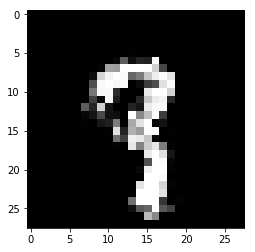

In [54]:
im = np.reshape(samples[3], (28, 28))
plt.imshow(im, cmap=plt.get_cmap('gray'))
plt.show()

## Customized Generation

In [55]:
total_epoch = 10
batch_size = 100
n_hidden = 256
n_input = 28 * 28
n_noise = 128
n_class = 10

In [56]:
X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_class])
Z = tf.placeholder(tf.float32, [None, n_noise])

In [59]:
def generator(noise, labels):
    with tf.variable_scope('generator'):

        inputs = tf.concat([noise, labels], 1) ##

        hidden = tf.layers.dense(inputs, n_hidden,
                                 activation=tf.nn.relu)
        output = tf.layers.dense(hidden, n_input,
                                 activation=tf.nn.sigmoid)

    return output


def discriminator(inputs, labels, reuse=None):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()

        inputs = tf.concat([inputs, labels], 1)

        hidden = tf.layers.dense(inputs, n_hidden,
                                 activation=tf.nn.relu)
        output = tf.layers.dense(hidden, 1,
                                 activation=None)

    return output

def get_noise(batch_size, n_noise):
    return np.random.uniform(-1., 1., size=[batch_size, n_noise])

In [60]:
G = generator(Z, Y)
D_real = discriminator(X, Y)
D_gene = discriminator(G, Y, True)

loss_D_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_real, labels=tf.ones_like(D_real)))
loss_D_gene = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_gene, labels=tf.zeros_like(D_gene)))

In [61]:
loss_D = loss_D_real + loss_D_gene
loss_G = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_gene, labels=tf.ones_like(D_gene)))

vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                           scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                           scope='generator')

train_D = tf.train.AdamOptimizer().minimize(loss_D,
                                            var_list=vars_D)
train_G = tf.train.AdamOptimizer().minimize(loss_G,
                                            var_list=vars_G)

In [62]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        _, loss_val_D = sess.run([train_D, loss_D],
                                 feed_dict={X: batch_xs, Y: batch_ys, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],
                                 feed_dict={Y: batch_ys, Z: noise})

    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))

    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G,
                           feed_dict={Y: mnist.test.labels[:sample_size],
                                      Z: noise})

        fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

        for i in range(sample_size):
            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()

            ax[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
            ax[1][i].imshow(np.reshape(samples[i], (28, 28)))

       # plt.savefig('samples2/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.close(fig)

print('Optimization Finished!')

Epoch: 0000 D loss: 0.007544 G loss: 7.249
Epoch: 0001 D loss: 0.006055 G loss: 7.612
Epoch: 0002 D loss: 0.01363 G loss: 6.798
Epoch: 0003 D loss: 0.03311 G loss: 5.198
Epoch: 0004 D loss: 0.03122 G loss: 7.453
Epoch: 0005 D loss: 0.05103 G loss: 7.839
Epoch: 0006 D loss: 0.06088 G loss: 6.813
Epoch: 0007 D loss: 0.06759 G loss: 7.385
Epoch: 0008 D loss: 0.02219 G loss: 7.382
Epoch: 0009 D loss: 0.05175 G loss: 6.107
Optimization Finished!


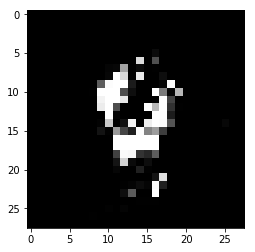

In [78]:
im = np.reshape(samples[6], (28, 28))
plt.imshow(im, cmap=plt.get_cmap('gray'))
plt.show()